# Credit Card Fraud Detection using SMOTE, Random Forest and Logistic Regression

In this kernel I will do some explorations trying to understand the fraud transaction patterns and them I will implement some models of machine learning.

I will implement technique an technique called SMOTE. The full form of SMOTE is Synthetic Minority Oversampling Technique. We can use SMOTE is particular cases where there is a dominant category in the dataset, which leads to unbalanced data. To account for the disparity in the number of values of each category, we use SMOTE to equalize the number of entries of each category to train the model without overfitting. 

## The Dataset

This dataset was taken from Kaggle.

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on http://mlg.ulb.ac.be/BruFence and http://mlg.ulb.ac.be/ARTML

Please cite: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015.

This process has been adapted as a learning experience from currently existing kernels on Kaggle.


## Importing the Libaries needed for Data Analysis and Visualization

In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

## Importing the Libraries needed for Machine Learning using SciKitPy

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix,recall_score,precision_recall_curve,auc,roc_curve,roc_auc_score,classification_report

## Reading the CSV File of the Dataset

In [58]:
data = pd.read_csv("creditcard.csv")

Let's load in the data and see how it looks. One key thing to note here is that there are no null values, which means we do not need to do any additional operations or clean the data with 0, mean or median. Another interesting thing to note in the dataset, is that apart from the Time, Amount and Class columns, the other column names have been anonymized due to privacy concerns and sensitive data. What we can already assume, is that the data in each of the anonymized rows is scaled correctly.

In [59]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

Let's now make the first visualization, and compare the number of transactions which are "Normal" with those that were "Fraud". There is a massive disparity in the number of Normal entries as compared to Fraud entries. This is normal when dealing with datasets related to fraud. Let's take a look at the "normal" columns, before we tackle the standardized columns.

In [60]:
data[["Time","Amount","Class"]].describe()

,Time,Amount,Class
count,284807.000000,284807.000000,284807.000000
mean,94813.859575,88.349619,0.001727
std,47488.145955,250.120109,0.041527
min,0.000000,0.000000,0.000000
25%,54201.500000,5.600000,0.000000
50%,84692.000000,22.000000,0.000000
75%,139320.500000,77.165000,0.000000
max,172792.000000,25691.160000,1.000000


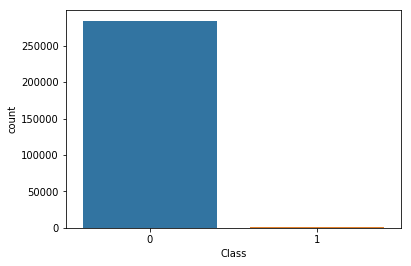

In [61]:
sns.countplot("Class",data=data)

In [62]:
normal_transaction_count = len(data[data["Class"]==0])
fraud_transaction_count = len(data[data['Class']==1])
percent_normal = normal_transaction_count/(normal_transaction_count + fraud_transaction_count)
percent_fraud = fraud_transaction_count/(normal_transaction_count + fraud_transaction_count)
print("Percentage of Normal Transactions is:", percent_normal *100)
print("Percentage of Fraud Transactions is:", percent_fraud * 100)

Percentage of Normal Transactions is: 99.82725143693798
Percentage of Fraud Transactions is: 0.1727485630620034


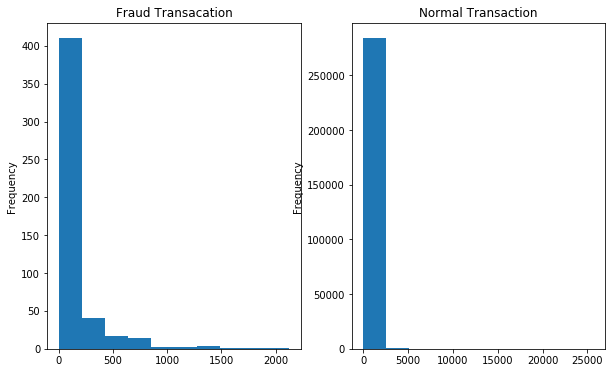

In [63]:
fraud_transaction = data[data["Class"]==1]
normal_transaction= data[data["Class"]==0]
plt.figure(figsize=(10,6))
plt.subplot(121)
fraud_transaction.Amount.plot.hist(title="Fraud Transacation")
plt.subplot(122)
normal_transaction.Amount.plot.hist(title="Normal Transaction")

## Time Features

Let's do some primary visualization to determine whether or not the Time column will be helpful during classification, and if it varies from Normal transactions to Fraudulent ones.

Here the Time is given in seconds, so we will convert it to Minutes, and Hours to get a better grasp of it's correlation with Fraud.

In [64]:
timedelta = pd.to_timedelta(data['Time'], unit='s')
data['Time_min'] = (timedelta.dt.components.minutes).astype(int)
data['Time_hour'] = (timedelta.dt.components.hours).astype(int)

(-1, 25)

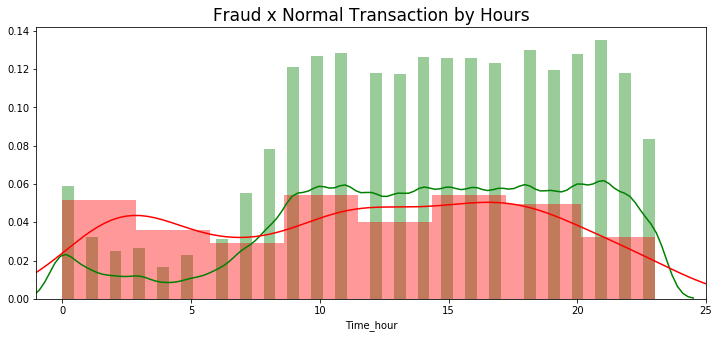

In [65]:
plt.figure(figsize =(12,5))
sns.distplot(data[data["Class"]==0]["Time_hour"],color="g")
sns.distplot(data[data["Class"]==1]["Time_hour"],color="r")
plt.title("Fraud x Normal Transaction by Hours",fontsize=17)
plt.xlim([-1,25])

(-1, 25)

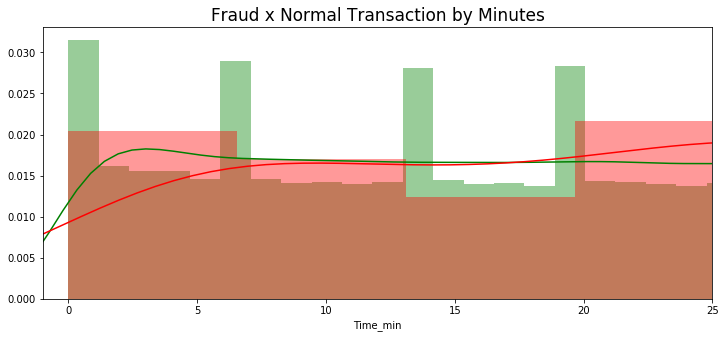

In [66]:
plt.figure(figsize =(12,5))
sns.distplot(data[data["Class"]==0]["Time_min"],color="g")
sns.distplot(data[data["Class"]==1]["Time_min"],color="r")
plt.title("Fraud x Normal Transaction by Minutes",fontsize=17)
plt.xlim([-1,25])

From these graphs, we can see that time does not seem to have any significant trends or patterns that could be useful.

## Analyzing the Amount for Fraud and Normal Transactions

Let's analyze the Fraud and Normal Transaction statistics. For ease of visibility and for a clear scale, let's transform the Amount Feature by taking a log of the value.

In [67]:
print("Fraud Transaction Statistics:")
fraud_transaction["Amount"].describe()

Fraud Transaction Statistics:


count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [68]:
print("Normal Transaction Statistics:")
normal_transaction["Amount"].describe()

Normal Transaction Statistics:


count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [69]:
data["Amount_log"] = np.log(data.Amount + 0.01)

Let's now explore the Amount by Class and see the distribution of Amount transactions using a Box Plot.

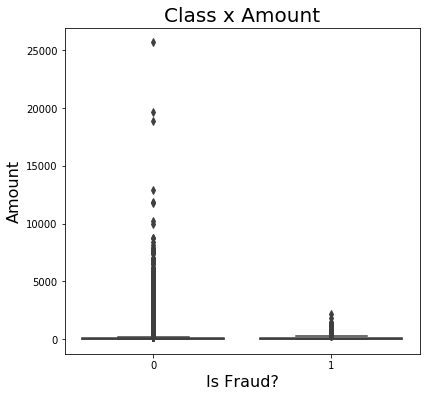

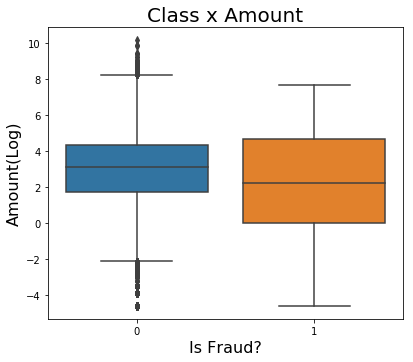

In [70]:
plt.figure(figsize = (14,6))
plt.subplot(121)
ax = sns.boxplot(x="Class",y="Amount",data=data)
ax.set_title("Class x Amount",fontsize=20)
ax.set_xlabel("Is Fraud?",fontsize=16)
ax.set_ylabel("Amount", fontsize=16)

plt.figure(figsize = (14,6))
plt.subplot(122)
ax1 = sns.boxplot(x="Class",y="Amount_log",data=data)
ax1.set_title("Class x Amount",fontsize=20)
ax1.set_xlabel("Is Fraud?",fontsize=16)
ax1.set_ylabel("Amount(Log)", fontsize=16)

plt.subplots_adjust(hspace = 0.6, top = 0.8)

Text(0.5,1,'Amounts x Minutes of Fraud and Normal Transactions')

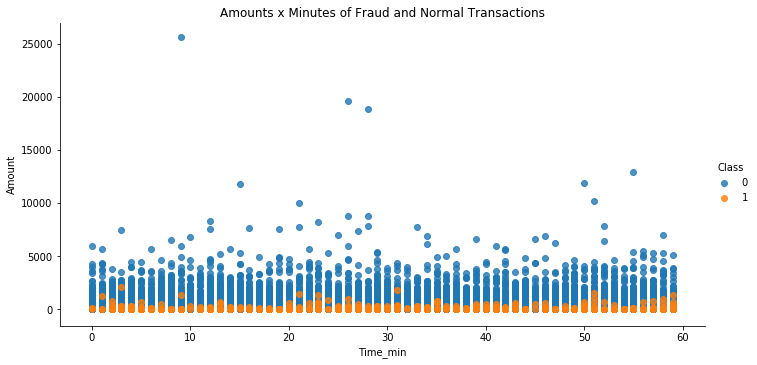

In [71]:
ax = sns.lmplot(y="Amount",x="Time_min",data=data,fit_reg=False,hue="Class", aspect=2.0)
plt.title("Amounts x Minutes of Fraud and Normal Transactions")

Text(0.5,1,'Amounts x Hour of Fraud and Normal Transactions')

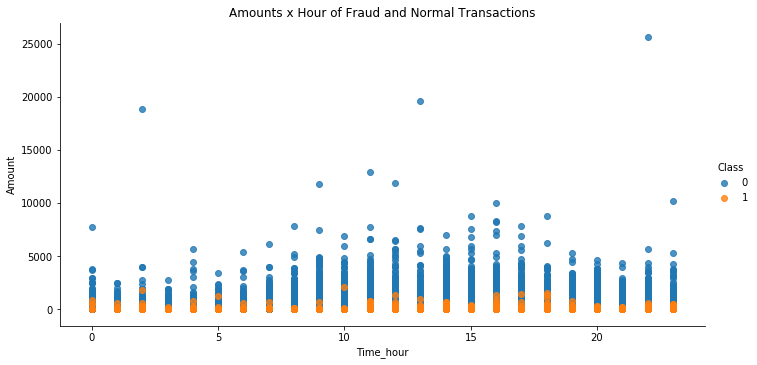

In [72]:
ax = sns.lmplot(y="Amount",x="Time_hour",data=data,fit_reg=False,hue="Class", aspect=2.0)
plt.title("Amounts x Hour of Fraud and Normal Transactions")

## Feature Analysis

Now we will plot each of the anonymized features by sorting them from Normal and Fraud transactions which will help us analyze the distribution and see whether any features are outliers or divergent from normal distribution for Fraudulent transactions.

First we will store the different columns in the variable "columns". We divide among fraud and normal by storing them in different variables "frauds" and "normals" based on the boolean value of their Class. We have alrady imported gridspec from the matplotlib library. 

Now until each of the columns has been traversed, we are making a distplot of the "frauds" and "normals" in different colors, Red and Green respectively. 

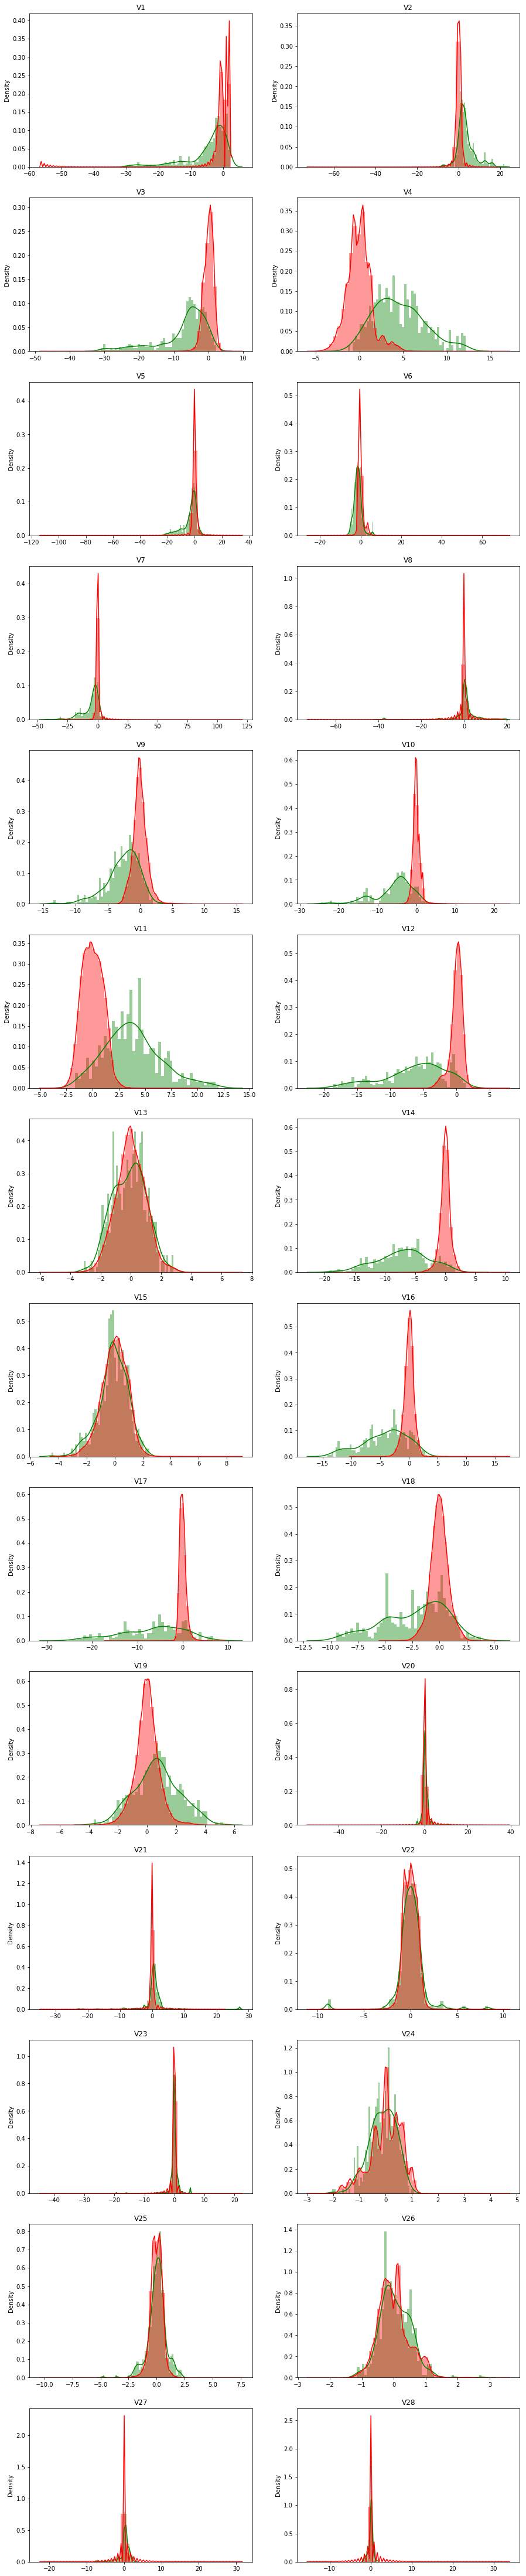

In [73]:
#Looking the V's features
columns = data.iloc[:,1:29].columns

frauds = data.Class == 1
normals = data.Class == 0

grid = gridspec.GridSpec(14, 2)
plt.figure(figsize=(15,20*4))

for n, col in enumerate(data[columns]):
    ax = plt.subplot(grid[n])
    sns.distplot(data[col][frauds], bins = 50, color='g') #Will receive the "semi-salmon" violin
    sns.distplot(data[col][normals], bins = 50, color='r') #Will receive the "ocean" color
    ax.set_ylabel('Density')
    ax.set_title(str(col))
    ax.set_xlabel('')
plt.show()


We can see an interesting diverging distribution in some of our features like V4, V9, V16, V17 and a lot more. 

## Feature Selection

Now we are going to select the features which are diverging from normal distribution for Fraudulent transactions. From the above distplots, we can determine the anonymized columns such as V9, V16, and V17 which can be useful for future classification.

In [20]:
data = data[["Time_hour","Time_min","V2","V3","V4","V9","V10","V11","V12","V14","V16","V17","V18","V19","V27","Amount","Class"]]

Converting the Amount to it's log value for the final dataframe to be processed.

In [21]:
data.Amount = np.log(data.Amount + 0.001)

Let's take a look at our final dataframe.

In [22]:
data.head()

,Time_hour,Time_min,V2,V3,V4,V9,V10,V11,V12,V14,V16,V17,V18,V19,V27,Amount,Class
0,0,0,-0.072781,2.536347,1.378155,0.363787,0.090794,-0.551600,-0.617801,-0.311169,-0.470401,0.207971,0.025791,0.403993,0.133558,5.008105,0
1,0,0,0.266151,0.166480,0.448154,-0.255425,-0.166974,1.612727,1.065235,-0.143772,0.463917,-0.114805,-0.183361,-0.145783,-0.008983,0.989913,0
2,0,0,-1.340163,1.773209,0.379780,-1.514654,0.207643,0.624501,0.066084,-0.165946,-2.890083,1.109969,-0.121359,-2.261857,-0.055353,5.936641,0
3,0,0,-0.185226,1.792993,-0.863291,-1.387024,-0.054952,-0.226487,0.178228,-0.287924,-1.059647,-0.684093,1.965775,-1.232622,0.062723,4.816249,0
4,0,0,0.877737,1.548718,0.403034,0.817739,0.753074,-0.822843,0.538196,-1.119670,-0.451449,-0.237033,-0.038195,0.803487,0.219422,4.248367,0


## Correlation Analysis

Let's find the correlation between each features with a heatmap.

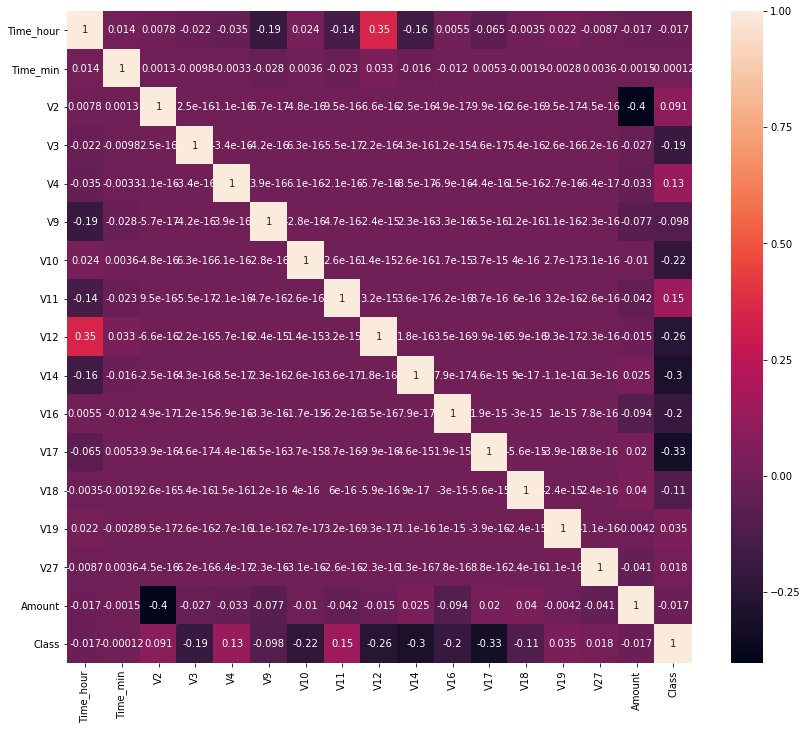

In [23]:
plt.figure(figsize=(14,12))
sns.heatmap(data.corr(),annot=True,linecolor='white')

## Data Preprocessing

Let's import the requirements from libraries Unbalanced Learn, which we will use for SMOTE.

In [24]:
from imblearn.pipeline import make_pipeline as make_pipeline_imb # To do our transformation in a unique time
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced

from sklearn.model_selection import train_test_split
from collections import Counter

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, fbeta_score, confusion_matrix, precision_recall_curve, accuracy_score

Now let's set up the X dataframe, which will contain the data on which we wish to use our classification techniques. Hence we will remove the Class column from X, as this is the value we wish to predict. We are setting up the X for the split.

In [25]:
X = data.drop(['Class'],axis=1).values

in y we will add the values of the Class column. 

In [26]:
y = data["Class"].values

This is a function we will use to better analyze the results of the classification. The factors by which we are analyzing are "Accuracy", "Precision" and "Recall".

Below that we are splitting the data into the test and training sets. Here we are doing a 25/75 split of the data.

We are storing the classification technique we wish to do in this iteration, Random Forest in the classifier variable.

Now we are setting up a SMOTE Pipeline, which can be done using an inbuilt library function called make_pipeline_imb. After we fit the model on the data, we can begin our predictions for the X test set.

In [80]:
def print_results(headline, true_value,pred):
    print(headline)
    print("accuracy: {}".format(accuracy_score(true_value, pred)))
    print("precision: {}".format(precision_score(true_value, pred)))
    print("recall: {}".format(recall_score(true_value, pred)))
    print("f2: {}".format(fbeta_score(true_value, pred, beta=2)))
    
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2, test_size=0.20)

classifier = RandomForestClassifier

smote_pipeline = make_pipeline_imb(SMOTE(random_state=4), \
                                   classifier(random_state=42))

smote_model = smote_pipeline.fit(X_train, y_train)
smote_prediction = smote_model.predict(X_test)

#Showing the diference before and after the transformation used
print("normal data distribution: {}".format(Counter(y)))
X_smote, y_smote = SMOTE().fit_sample(X, y)
print("SMOTE data distribution: {}".format(Counter(y_smote)))

normal data distribution: Counter({0: 284315, 1: 492})
SMOTE data distribution: Counter({0: 284315, 1: 284315})


## Evaluating the SMOTE Model and Random Forest

In [81]:
print("Confusion Matrix: ")
print(confusion_matrix(y_test, smote_prediction))

print('\nSMOTE Pipeline Score {}'.format(smote_pipeline.score(X_test, y_test)))

print_results("\nSMOTE + RandomForest classification", y_test, smote_prediction)

Confusion Matrix: 
[[56863    15]
 [   13    71]]

SMOTE Pipeline Score 0.9995084442259752

SMOTE + RandomForest classification
accuracy: 0.9995084442259752
precision: 0.8255813953488372
recall: 0.8452380952380952
f2: 0.8412322274881516


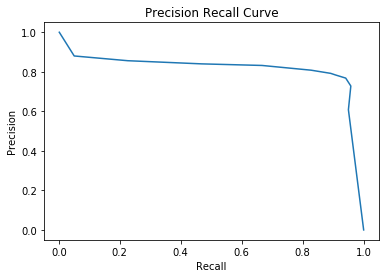

In [29]:
y_pred_prob = smote_pipeline.predict_proba(X_test)[:,1]

# Generate precision recall curve values: precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

## The Overfitting Problem

Here we are running into an issue with Overfitting. This is occuring due to the problem in data balance. We can fix this overfitting problem by using a Grid Search on the dataset which functions as cross validation.

Overfitting happens when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data. This means that the noise or random fluctuations in the training data is picked up and learned as concepts by the model. The problem is that these concepts do not apply to new data and negatively impact the models ability to generalize.

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.grid_search import GridSearchCV

In [31]:
#params of the model
param_grid = {"max_depth": [3,5, None],
              "n_estimators":[3,5,10],
              "max_features": [5,6,7,8]}

# Creating the classifier
model = RandomForestClassifier(max_features=3, max_depth=2 ,n_estimators=10, random_state=3, criterion='entropy', n_jobs=1, verbose=1 )

In [32]:
grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.8s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.9s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.4s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.3s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.5s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.4s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.3s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.1s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.2s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.6s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   11.2s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   10.9s finished
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=2, max_features=3, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=3, verbose=1, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [3, 5, None], 'n_estimators': [3, 5, 10], 'max_features': [5, 6, 7, 8]},
       pre_dispatch='2*n_jobs', refit=True, scoring='recall', verbose=0)

In [33]:
print(grid_search.best_score_)
print(grid_search.best_params_)

0.7795255580665406
{'max_depth': 5, 'max_features': 8, 'n_estimators': 5}


Running the Fit.

In [34]:
rf = RandomForestClassifier(max_depth=5, max_features = 7, n_estimators = 10)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features=7, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Printing the Training Score.

In [35]:
print("Training score data: ")
print(rf.score(X_train, y_train))

Training score data: 
0.9995786615481848


In [36]:
y_pred = rf.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print_results("RF classification", y_test, y_pred)

[[71068     9]
 [   26    99]]
RF classification
accuracy: 0.9995084407741356
precision: 0.9166666666666666
recall: 0.792
f2: 0.8141447368421052


## Feature Important Plot

Let's plot a barplot of the importance of each feature used in Random Forest Algorithm. From this we will be able to see which of these features affected the result set the most.

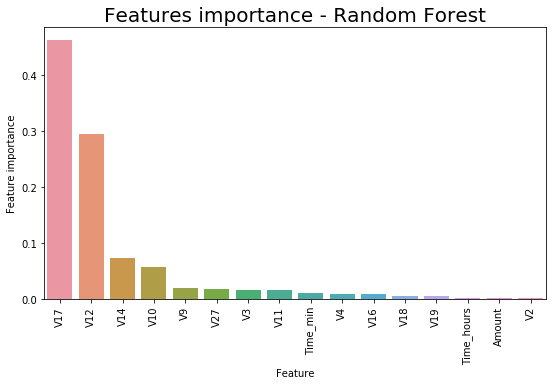

In [37]:
features = ["Time_min", 'Time_hours',"V2","V3","V4","V9","V10","V11","V12","V14","V16","V17","V18","V19","V27","Amount"]

# Credits to Gabriel Preda
# https://www.kaggle.com/gpreda/credit-card-fraud-detection-predictive-models
plt.figure(figsize = (9,5))

feat_import = pd.DataFrame({'Feature': features, 'Feature importance': rf.feature_importances_})
feat_import = feat_import.sort_values(by='Feature importance',ascending=False)

g = sns.barplot(x='Feature',y='Feature importance',data=feat_import)
g.set_xticklabels(g.get_xticklabels(),rotation=90)
g.set_title('Features importance - Random Forest',fontsize=20)
plt.show() 

The top 4 feature are V17, V14, V12, V10 corresponds to 75% of total.

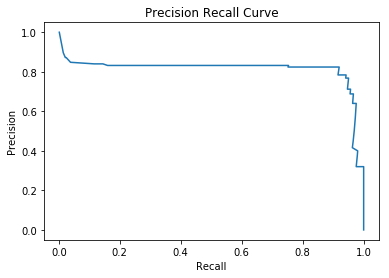

In [38]:
#Predicting proba
y_pred_prob = rf.predict_proba(X_test)[:,1]

# Generate precision recall curve values: precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

In [39]:
results = cross_val_score(rf,X_train, y_train, cv=10, scoring='recall')
results

array([0.75675676, 0.81081081, 0.75675676, 0.64864865, 0.78378378,
       0.83783784, 0.75675676, 0.69444444, 0.75      , 0.77777778])

## Modelling Logistic Regression

Here we are going to be testing the same dataset by using Logistic Regression. To find the ideal parameters to use Logistic Regression for, we will use Grid Search which will run by each iteration and combination to determine the ideal combination for the highest precision and accuracy.

In [40]:
param_grid = {'C': [0.01, 0.1, 1, 10],
             'penalty':['l1', 'l2']}

logreg = LogisticRegression(random_state=2)

grid_search_lr = GridSearchCV(logreg, param_grid=param_grid, scoring='recall', cv=5)

grid_search_lr.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=2, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, scoring='recall', verbose=0)

In [41]:
# The best recall obtained
print(grid_search_lr.best_score_)
#Best parameter on trainning set
print(grid_search_lr.best_params_)

0.5831174818010396
{'C': 1, 'penalty': 'l2'}


## Setting the best parameters as parameters for the model

In [77]:
# Creating the model 
logreg = LogisticRegression(C=1, penalty='l2',random_state=2)

#Fiting the model
logreg.fit(X_train, y_train)
           
# Printing the Training Score
print("Cross Validation of X and y Train: ")
print(cross_val_score(logreg,X_train, y_train, cv=5, scoring='recall'))

Cross Validation of X and y Train: 
[0.60810811 0.55405405 0.61643836 0.54794521 0.5890411 ]


In [78]:
y_pred = logreg.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print("")
print_results("LogReg classification", y_test, y_pred)

[[71070     7]
 [   50    75]]

LogReg classification
accuracy: 0.9991994606893064
precision: 0.9146341463414634
recall: 0.6
f2: 0.6443298969072164


## Precision Recall Curve for Logistic Regression

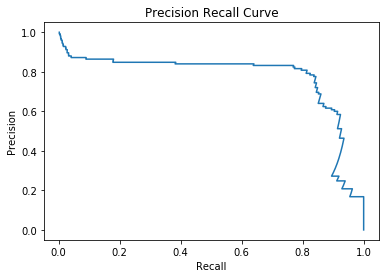

In [76]:
#Predicting proba
y_pred_prob = logreg.predict_proba(X_test)[:,1]

# Generate precision recall curve values: precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.show()

70% Accuracy is not bad for Logistic Regression, however we found a much higher accuracy with Random Forest. 

## Conclusion

The highest values of Normal transactions are 25691.16 while of Fraudulent transactions are just 2125.87. 

The average value of normal transactions are small(USD 88.29) than fraudulent transactions that is USD 122.21.

We got the best score when we use the SMOTE (OverSampling) + RandomForest, that performed a f2 score of 0.8414~

This is a considerably difference by the second best model that is 0.8104 that uses just RandomForests with some Hyper Parameters.

The worst model was Logistic Regression where we used GridSearchCV to get the Best parameters to fit and predict where the recall was ~0.6 and f2 ~0.70.